# Esempio di segmentazione a soglia - Notebook 3.1

Import delle librerie necessarie per la simulazione

In [14]:

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from sklearn.cluster import k_means
import pydicom
import skfuzzy as fuzz

import dei dati e stampa a video dei metadati del phantom

In [15]:
# load image
ds = pydicom.dcmread('../data/phantom.dcm')
image = ds.pixel_array
print(ds)


Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.134.1762810675.1868.1068286415.435
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 0.0.0.0
(0002,0013) Implementation Version Name         SH: 'NOTSPECIFIED'
(0002,0016) Source Application Entity Title     AE: 'NOTSPECIFIED'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008,0012) Instance Creation Date              DA: '20031108'
(0008,0013) Instance Creation Time              TM: '122956'
(0008,0014) Instance Creator UID                UI: 0.0.0.0
(

Segmentazione a soglia basata sull'istogramma dell'immagine

928


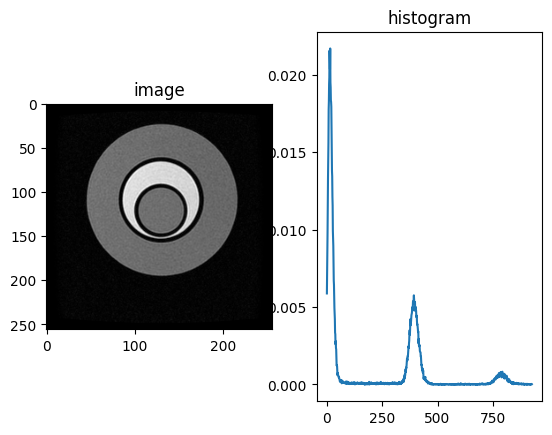

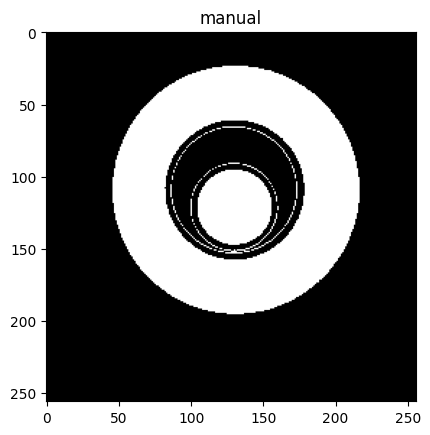

In [16]:
# get histogram
p = np.max(image, None)
print(p)
counts, bins = np.histogram(image, bins = p)

# display phantom image and image histogram
fig, ax = plt.subplots(1,2)
ax[0].imshow(image, cmap = "gray")
ax[1].plot(counts[1:]/np.sum(counts, None))
ax[0].set_title('image')
ax[1].set_title('histogram')
plt.show()

# manual segmentation of water signal (dall'isto sopra 200 e sotto 600)
mask = np.zeros((ds.Rows, ds.Columns), None)

id = np.logical_and(image > 200, image<600)
mask[id] = 255
plt.figure()
plt.imshow(mask, cmap = "gray")
plt.title('manual')
plt.show()

Segmentazione tramite il metodo di Otsu

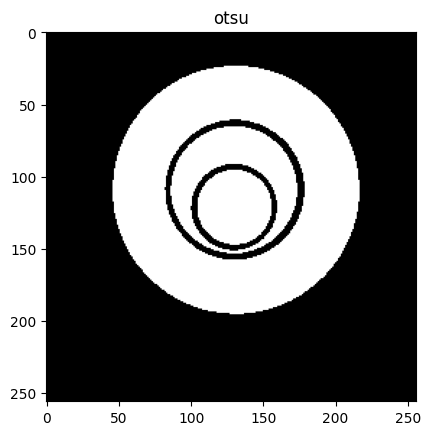

In [17]:
# otsu algorithm
otsu_thresh = threshold_otsu(image)
image_otsu = image > otsu_thresh
plt.figure()
plt.imshow(image_otsu, cmap = 'gray')
plt.title('otsu')
plt.show()

Segmentazione tramite clustering *k-means*

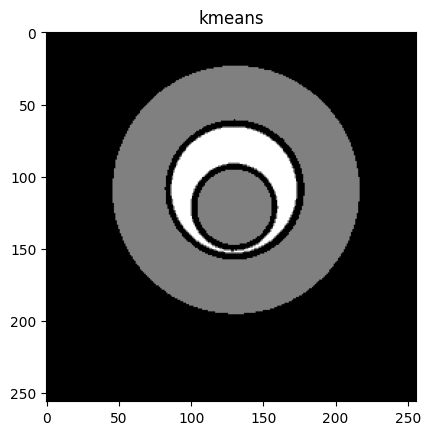

soglie =  [204.31011186 589.21653952]


In [18]:
#### kmeans ####
x = image.reshape((-1,1))
centroid, label, inertia = k_means(x, n_clusters = 3)
image_classes = label.reshape(image.shape)
plt.figure()
plt.imshow(image_classes, cmap = 'gray')
plt.title('kmeans')
plt.show()
c = np.sort(centroid, axis = 0)
T = np.array([np.mean(c[0:2]), np.mean(c[1:3])])
print("soglie = ", T)

Segmentazione tramite *fuzzy c-means*

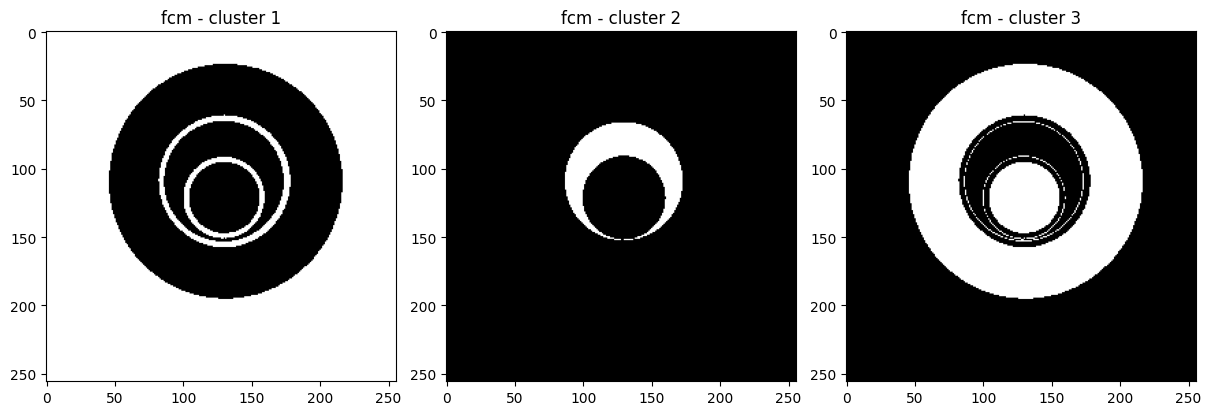

In [19]:
# x: vettore dei pixel (N,) o (N,1). Qui lo porto a (1, N) come richiesto da cmeans
x1 = x.astype(np.float64).reshape(1, -1)

# FCM
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    x1,              # data: (features, samples)
    c=3,             # numero cluster
    m=2.0,           # fuzziness
    error=1e-5,
    maxiter=1000,
    init=None        
)

# hard label (cluster più probabile)
labels = np.argmax(u, axis=0)  # (N,)

mask1 = (labels == 0).reshape(image.shape)
mask2 = (labels == 1).reshape(image.shape)
mask3 = (labels == 2).reshape(image.shape)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
ax[0].imshow(mask1, cmap='gray'); ax[0].set_title('fcm - cluster 1')
ax[1].imshow(mask2, cmap='gray'); ax[1].set_title('fcm - cluster 2')
ax[2].imshow(mask3, cmap='gray'); ax[2].set_title('fcm - cluster 3')
plt.show()
